In [1]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2022-04-18 01:52:11.186205: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


2022-04-18 01:52:15.727476: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-18 01:52:15.729737: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-18 01:52:15.783201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 01:52:15.784435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-04-18 01:52:15.784569: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-18 01:52:15.827812: I tensorflow/stream_executor/platform/defa

In [3]:
SEED = 1000
IMG_SIZE = 100
BATCH_SIZE = 128

TRAIN_DIR = '/home/dev/Documents/datasets/camo/train'

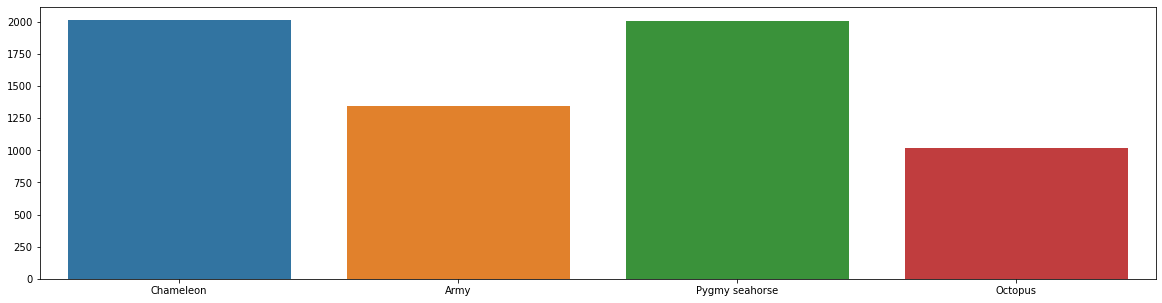

In [4]:
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
  files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
  class_names.append(f)
  class_count.append(len(files))
  train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.show()

In [5]:
train_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.3,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    dtype=tf.float32
)

In [6]:
test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    dtype=tf.float32
)

In [7]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode = 'sparse',
    seed=SEED
)

Found 5011 images belonging to 4 classes.


In [8]:
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode = 'sparse',
    seed=SEED
)

Found 1252 images belonging to 4 classes.


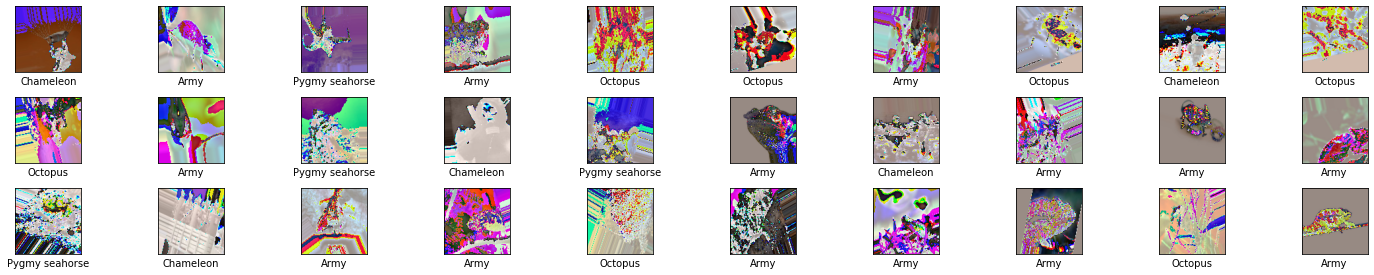

In [9]:
imgs, labels = next(train_batch)
i=0
plt.figure(figsize=(20,5))
for img,label in zip(imgs,labels):
  plt.subplot(4,10,i+1)
  plt.imshow(img.astype('uint8'))
  plt.xlabel(class_names[label.astype('int32')])
  plt.xticks([])
  plt.yticks([])
  i+=1
  if i==30:
    break
plt.tight_layout()
plt.show()

In [10]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

2022-04-18 01:53:12.611469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-18 01:53:12.612005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 01:53:12.612495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.2GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2022-04-18 01:53:12.612556: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcu

In [11]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [12]:
base_model.trainable = False

In [17]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               1313

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

In [20]:
h = model.fit(train_batch, 
              epochs=50,
              steps_per_epoch = 5011 // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = 1252 // BATCH_SIZE,
              callbacks=[reduce_lr]
             )

Epoch 1/50
39/39 [==============================] - 142s 4s/step - loss: 1.0013 - accuracy: 0.6247 - val_loss: 0.6115 - val_accuracy: 0.8524
Epoch 2/50
39/39 [==============================] - 119s 3s/step - loss: 0.3400 - accuracy: 0.8961 - val_loss: 0.4737 - val_accuracy: 0.8741
Epoch 3/50
39/39 [==============================] - 109s 3s/step - loss: 0.2850 - accuracy: 0.9060 - val_loss: 0.4143 - val_accuracy: 0.8759
Epoch 4/50
39/39 [==============================] - 111s 3s/step - loss: 0.2477 - accuracy: 0.9158 - val_loss: 0.3573 - val_accuracy: 0.8837
Epoch 5/50
39/39 [==============================] - 113s 3s/step - loss: 0.2307 - accuracy: 0.9204 - val_loss: 0.3419 - val_accuracy: 0.8863
Epoch 6/50
39/39 [==============================] - 118s 3s/step - loss: 0.2113 - accuracy: 0.9323 - val_loss: 0.3873 - val_accuracy: 0.8819
Epoch 7/50
39/39 [==============================] - 117s 3s/step - loss: 0.2064 - accuracy: 0.9322 - val_loss: 0.3664 - val_accuracy: 0.8750

Epoch 00007:

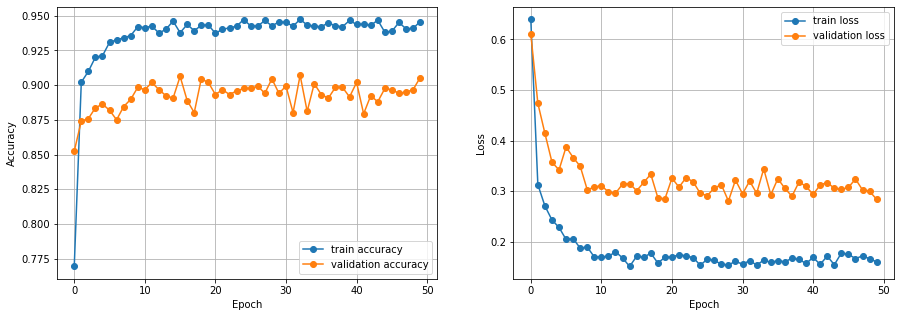

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()